# MathFin Practice

## Jey@aims.ac.za

In [ ]:
import numpy as np
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.preprocessing import StandardScaler

# Keras imports
from keras.models import Sequential
from keras.layers import Dense
import yfinance as yf


# Here we import the LSTM cell which allows us to make LSTM cells
# Here is the documentation for the LSTM cell in Keras https://keras.io/layers/recurrent/#lstm
from keras.layers import LSTM

# 1. Reading and Cleaning th data

In [ ]:
#dataframe = pandas.read_csv('JSEJF.csv',engine='python', sep = ',', header=0)
dataframe = yf.download("JSEJF",start="2010-01-01",end="2019-12-31")

[*********************100%***********************]  1 of 1 completed


In [ ]:
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,8.25,8.25,8.25,8.25,0.198083,400
2010-01-04,8.20,8.20,8.20,8.20,0.196882,200
2010-01-05,8.45,8.45,8.45,8.45,0.202885,2000
2010-01-06,8.45,8.45,8.40,8.40,0.201684,2900
2010-01-07,8.40,8.40,8.40,8.40,0.201684,0


In [ ]:
dataframe.shape

(2516, 6)

### Cleaning the data by removing rows with empty entries

In [ ]:
dataframe = dataframe.dropna()
dataframe = dataframe.reset_index(drop=True)

In [ ]:
dataframe.shape

(2516, 6)

Seems like not the data doesn't have rows with empty emptries

# 2. Creation of a new dataframe indexed by 'Data'

In [ ]:
dataset = dataframe.drop(columns = ['High','Low','Adj Close','Volume'])

In [ ]:
dataset.head()

,Open,Close
0,8.25,8.25
1,8.20,8.20
2,8.45,8.45
3,8.45,8.40
4,8.40,8.40


## Checking the shape

In [ ]:
dataset.shape

(2516, 2)

## Creation of an array containing all close values

In [ ]:
dataset_close = dataset['Close'].values
dataset_close = dataset_close.astype('float32')

In [ ]:
dataset_close

array([8.25, 8.2 , 8.45, ..., 8.61, 8.9 , 8.74], dtype=float32)

### Checking the shape

In [ ]:
dataset_close.shape

(2516,)

## Reshaping the data into a long vector

In [ ]:
dataset_close = dataset_close.reshape(-1,1)

### Check of the new shape

In [ ]:
dataset_close.shape

(2516, 1)

## Plot of the all data

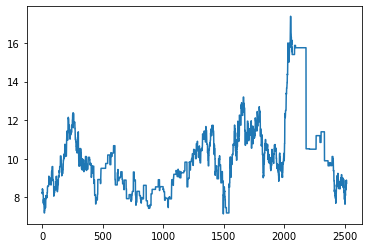

In [ ]:
plt.plot(dataset_close)
plt.show()

# 4. Scaling the data

For the scaling function it's asked to used "StandardScaler" but it doesn't give values between 0 and 1. That the reason why we use "MinMaxScaler". But the program will still run with either the following variable "scaler" is set with StandardScalar or MinMaxScaler

In [ ]:
#scaler = StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
dataset_close = scaler.fit_transform(dataset_close)

In [ ]:
dataset_close

array([[0.10752684],
       [0.10263926],
       [0.12707716],
       ...,
       [0.14271742],
       [0.17106545],
       [0.15542519]], dtype=float32)

# 5. Splitting the data in training and testing data

In [ ]:
train_size = int(len(dataset_close) * 0.70) ## Length of the training data

test_size = len(dataset_close) - train_size ## Length of the testing data

# Split the data manually (note that here we are not shuffling the data)
train, test = dataset_close[0:train_size,:], dataset_close[train_size:len(dataset_close),:]

The ratio between the training and the testing depends on factors like how long is the data (small or large). But defaultly is recommanded to use ratio in range 70%-80% for the training and 20%-30% for the testing. That's why we prefered to use 70% and 30%

# 6. Create the labels for the dataset

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 10

# Split the data into training features and training targets
trainX, trainY = create_dataset(train, look_back)

# Split the data into testing features and testing targets
testX, testY = create_dataset(test, look_back)

### Checking the new shape

In [ ]:
print('Train X shape ',trainX.shape)
print('Train Y shape',trainY.shape)
print('Test X shape ',testX.shape)
print('Test Y shape ',testY.shape)

Train X shape  (1750, 10)
Train Y shape (1750,)
Test X shape  (744, 10)
Test Y shape  (744,)


## Reshape to [samples, timesteps, features]

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
print('Train X shape ',trainX.shape)
print('Train Y shape',trainY.shape)
print('Test X shape ',testX.shape)
print('Test Y shape ',testY.shape)

Train X shape  (1750, 10, 1)
Train Y shape (1750,)
Test X shape  (744, 10, 1)
Test Y shape  (744,)


# 7. Train and test a Stateful LSTM model. State your final training and testing losses.

In [ ]:
# Define the model in Keras
model = Sequential()

In [ ]:
# This is how we add an LSTM cell. (We can stack multiple cells on top of each other by repeating this line)
model.add(LSTM(8, batch_input_shape=(1, 10, 1), stateful=True))

In [ ]:
# We have to add a fully connected layer of the LSTM to output the predictions. Here we only have 1 node because
# our time-series prediction is expecting one output. 
model.add(Dense(1))

In [ ]:
# We define our loss function. Here since we are dealing with numerical data, one option is to use mean squared error.
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Check the number of parameters. Always a good idea to take a look at the model from Keras' point of view
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (1, 8)                    320       
_________________________________________________________________
dense_23 (Dense)             (1, 1)                    9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


## Start training the model

In [ ]:
for i in range(10):
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2, shuffle=False)
    model.reset_states()
# Estimate model performance

Epoch 1/1
 - 13s - loss: 0.0013
Epoch 1/1
 - 11s - loss: 0.0012
Epoch 1/1
 - 10s - loss: 8.6075e-04
Epoch 1/1
 - 11s - loss: 6.7301e-04
Epoch 1/1
 - 15s - loss: 5.7548e-04
Epoch 1/1
 - 13s - loss: 5.2735e-04
Epoch 1/1
 - 10s - loss: 5.0375e-04
Epoch 1/1
 - 11s - loss: 4.9149e-04
Epoch 1/1
 - 15s - loss: 4.8343e-04
Epoch 1/1
 - 16s - loss: 4.7564e-04


The loss after fitting the model is: 4.7564e-04

# 8. Predict on the test data and prepare the data for plotting

In [ ]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, batch_size=1, verbose=0)
model.reset_states()
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))

testScore = model.evaluate(testX, testY, batch_size=1, verbose=0)
model.reset_states()
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))

# generate predictions for training
trainPredict = model.predict(trainX, batch_size=1)
testPredict = model.predict(testX, batch_size=1)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset_close)-1, :] = testPredict

### We need to reshape  and shifting testY for the plot

In [ ]:
testY = testY.reshape(-1,1)

In [ ]:
# shift test predictions for plotting
testYPlot = np.empty_like(dataset_close)
testYPlot[:, :] = np.nan
testYPlot[len(trainY)+(look_back*2)+1:len(dataset_close)-1, :] = testY

### Plot of train test and prediction

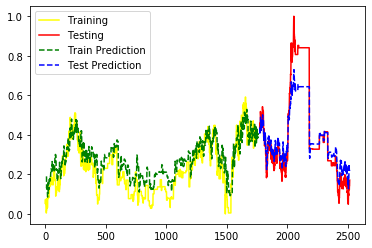

In [ ]:
#plt.plot(dataset_close)
plt.plot(trainY, color = 'yellow', label = 'Training')
plt.plot(testYPlot, color = 'red', label = 'Testing')
plt.plot(trainPredictPlot,'r--',color = 'green', label = 'Train Prediction')
plt.plot(testPredictPlot,'r--', color = 'blue', label = 'Test Prediction')
plt.legend()
plt.show()

# 9. Plot of Open today's values and prediction values

In [ ]:
dataset_open = dataset['Open'].values
dataset_open = dataset_open.astype('float32')
dataset_open = dataset_open.reshape(-1,1)
dataset_open = scaler.fit_transform(dataset_open)

### Preparing the open values for the plot

In [ ]:
# shift test Open values for plotting
openPlot = np.empty_like(dataset_open)
openPlot[:, :] = np.nan
openPlot[len(trainY)+(look_back*2)+1:len(dataset_open)-1, :] = dataset_open[len(trainY)+(look_back*2)+1:len(dataset_close)-1, :] 

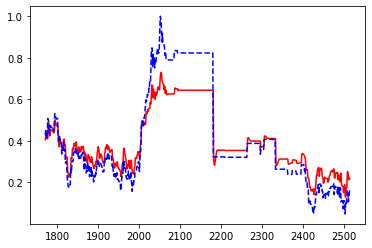

In [ ]:
plt.plot(testPredictPlot,color = 'red')
plt.plot(openPlot,'r--',color = 'blue')


# 10. Training the model with unscalled data

## Using "inverse_transform" to recorver our unscalled close values

In [ ]:
dataset_cl_unscaled = scaler.inverse_transform(dataset_close)

In [ ]:
dataset_cl_unscaled.shape

(2516, 1)

In [ ]:
dataset_cl_unscaled

array([[8.273656 ],
       [8.22258  ],
       [8.477957 ],
       ...,
       [8.641397 ],
       [8.9376335],
       [8.774193 ]], dtype=float32)

## Splitting the unscalled data to train and test

In [ ]:
train_size = int(len(dataset_cl_unscaled) * 0.70) ## Length of the training data

test_size = len(dataset_cl_unscaled) - train_size ## Length of the testing data

# Split the data manually (note that here we are not shuffling the data)
train, test = dataset_cl_unscaled[0:train_size,:], dataset_cl_unscaled[train_size:len(dataset_cl_unscaled),:]

## Create the labels for the dataset

In [ ]:
look_back = 10

# Split the data into training features and training targets
trainX, trainY = create_dataset(train, look_back)

# Split the data into testing features and testing targets
testX, testY = create_dataset(test, look_back)

### Checking the labeling 

In [ ]:
print('Train X shape ',trainX.shape)
print('Train Y shape',trainY.shape)
print('Test X shape ',testX.shape)
print('Test Y shape ',testY.shape)

Train X shape  (1750, 10)
Train Y shape (1750,)
Test X shape  (744, 10)
Test Y shape  (744,)


## Reshape to [samples, timesteps, features]

In [ ]:

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print('Train X shape ',trainX.shape)
print('Train Y shape',trainY.shape)
print('Test X shape ',testX.shape)
print('Test Y shape ',testY.shape)

Train X shape  (1750, 10, 1)
Train Y shape (1750,)
Test X shape  (744, 10, 1)
Test Y shape  (744,)


## Train and test a Stateful LSTM model. State your final training and testing losses

In [ ]:

# Define the model in Keras
model = Sequential()
# This is how we add an LSTM cell. (We can stack multiple cells on top of each other by repeating this line)
model.add(LSTM(8, batch_input_shape=(1, 10, 1), stateful=True))

# We have to add a fully connected layer of the LSTM to output the predictions. Here we only have 1 node because
# our time-series prediction is expecting one output. 
model.add(Dense(1))
# We define our loss function. Here since we are dealing with numerical data, one option is to use mean squared error.
model.compile(loss='mean_squared_error', optimizer='adam')
# Check the number of parameters. Always a good idea to take a look at the model from Keras' point of view
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (1, 8)                    320       
_________________________________________________________________
dense_24 (Dense)             (1, 1)                    9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


### Starting the training

In [ ]:
for i in range(10):
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2, shuffle=False)
    model.reset_states()
# Estimate model performance

Epoch 1/1
 - 14s - loss: 9.7791
Epoch 1/1
 - 15s - loss: 0.9184
Epoch 1/1
 - 14s - loss: 0.5410
Epoch 1/1
 - 11s - loss: 0.2915
Epoch 1/1
 - 12s - loss: 0.1915
Epoch 1/1
 - 12s - loss: 0.1440
Epoch 1/1
 - 13s - loss: 0.1199
Epoch 1/1
 - 13s - loss: 0.1048
Epoch 1/1


The loss is 0.1156

### Preparing data for the plots

In [ ]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, batch_size=1, verbose=0)
model.reset_states()
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))

testScore = model.evaluate(testX, testY, batch_size=1, verbose=0)
model.reset_states()
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))

# generate predictions for training
trainPredict = model.predict(trainX, batch_size=1)
testPredict = model.predict(testX, batch_size=1)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_cl_unscaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_cl_unscaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset_cl_unscaled)-1, :] = testPredict

In [ ]:
testY = testY.reshape(-1,1)

In [ ]:
# shift test predictions for plotting
testYPlot = np.empty_like(dataset_close)
testYPlot[:, :] = np.nan
testYPlot[len(trainY)+(look_back*2)+1:len(dataset_close)-1, :] = testY

### Plot

In [ ]:
#plt.plot(dataset_close)
plt.plot(trainY, color = 'yellow', label = 'Training')
plt.plot(testYPlot, color = 'red', label = 'Testing')
plt.plot(trainPredictPlot,'r--',color = 'green', label = 'Train Prediction')
plt.plot(testPredictPlot,'r--', color = 'blue', label = 'Test Prediction')
plt.legend()
plt.show()

## With the open data

In [ ]:

unscaled_dataset_open = scaler.inverse_transform(dataset_open)

In [ ]:
unscaled_dataset_open

In [ ]:
# shift test Open values for plotting
openPlot = np.empty_like(unscaled_dataset_open)
openPlot[:, :] = np.nan
openPlot[len(trainY)+(look_back*2)+1:len(unscaled_dataset_open)-1, :] = unscaled_dataset_open[len(trainY)+(look_back*2)+1:len(unscaled_dataset_open)-1, :]

In [ ]:
plt.plot(testPredictPlot,color = 'red')
plt.plot(openPlot,'r--',color = 'blue')